### Import Libraries

In [12]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import scipy.stats as scs
import math
from scipy import sparse
from scipy.sparse import csr_matrix
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy.stats as st

### Initial Setup

In [13]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))



======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


### Creating Out-of-Sample

In [14]:
Ndriver = len(np.unique(driver)) # 50


# -------- Insert your code here -------- #
# if Path(filename_save_out+'.npz').is_file():
#     Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
if Path('test_02'+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz('test_02' + '.npz')
else:
    np.random.seed(1622)
    
    # 100,000 scenarios by 50 drivers
    y_out = sqrt_rho.dot(np.random.normal(0, 1, (Ndriver,Nout))).T
    # idiosyncratic component independent across CPs j
    z_out = np.random.normal(0, 1, (K,Nout)).T #1 z for each CP 100,000 x 100
    # Losses of CP
    Losses_out = np.zeros((Nout, K))
    # creditworthiness 100,000 scenarios by 100 CPs
    w = np.zeros((Nout, K)) 
    # Generating Scenarios

    # -------- Insert your code here -------- #
    
    for s in range(0, Nout): # 100,000 scenarios
        
        # -------- Insert your code here -------- #
        for k in range(0 ,K): # 100 CPs
            # Creditworthiness index of counterparty j
            w[s,k] = beta[k] * y_out[s,int(driver[k])-1] + np.sqrt(1-beta[k]**2) * z_out[s,k]
            # append w into boundary
            temp = np.append(w[s,k], CS_Bdry[k]) 
            # since boundary si already sorted, sorting it with w will get the w into right position
            sorted_temp = np.sort(temp)
            # get the index position of w (the rating)
            index_pos = np.argwhere(sorted_temp == w[s,k])
            # Calculated out-of-sample losses (100000 x 100)
            Losses_out[s,k] = exposure[k, index_pos] # get the right loss for CP given w
    Losses_out = sparse.csr_matrix(Losses_out)
    scipy.sparse.save_npz('test_02' + '.npz', Losses_out)

Convert sparse to array

In [15]:
# Losses_out = sparse.csr_matrix(Losses_out)
# scipy.sparse.save_npz('test_01' + '.npz', Losses_out)
# from scipy.sparse import csr_matrix
Losses_out = csr_matrix.toarray(Losses_out)


### Calculating VaR and CVaR

In [16]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # 

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

In [17]:
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        
        lossz = np.sort(Losses_out.dot(x0[portN]))
        VaRout[portN, q] = lossz[int(math.ceil(Nout * alf)) - 1]
        VaRinN[portN, q] = np.mean(lossz) + scs.norm.ppf(alf) * np.std(lossz) 
        
        CVaRout[portN, q] = (1/(Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf) * VaRout[portN,q]\
                                                      + sum(lossz[int(math.ceil(Nout * alf)):]))        
        CVaRinN[portN, q] = np.mean(lossz) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(lossz)


### Monte Carlo Approximation 1 and 2

In [127]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)
        
np.random.seed(1234)

for tr in range(1, N_trials + 1): # 100 trial
    # Monte Carlo approximation 1 SETUP
    Losses_inMC1 = np.zeros((Nin,K)) # MC1 losses 5000 by 100. 1 CP has 5000 losses
    w_inMC1 = np.zeros((Nout, K)) # creditworthiness 5000 scenarios by 100 CPs
    
    # Monte Carlo approximation 2 SETUP
    Losses_inMC2 = np.zeros((Nin,K)) # MC1 losses 5000 by 100. 1 CP has 5000 losses
    w_inMC2 = np.zeros((Nout, K)) # creditworthiness 5000 scenarios by 100 CPs
    
    # generating big y table 5000 x50
    y_in = sqrt_rho.dot(np.random.normal(0, 1, (Ndriver,Nin))).T
    # generating big z table 5000 x 100
    z_in = np.random.normal(0, 1, (K,Nin)).T #1 z for each CP
    
    # MC 1
    for s in range(1, int(np.ceil(Nin / Ns) + 1)): # systemic scenarios # 1000  
#         y_inMC1 = sqrt_rho.dot(np.random.normal(0, 1, (Ndriver,1))).T # y of 1 by 50
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic # 5
#             z_inMC1 = np.random.normal(0, 1, (K,1)) # z of 100 by 1
            for k in range(1, K+1): # 100 CPs (only takes 1000z out of 5000 y)
                # Creditworthiness index of counterparty j
                w_inMC1[s-1,k-1] = beta[k-1] * y_in[s-1,int(driver[k-1])-1] + np.sqrt(1-beta[k-1]**2) *\
                z_in[Ns*(s-1)+si-1,k-1]
                # append w into boundary
                temp = np.append(w_inMC1[s-1,k-1], CS_Bdry[k-1])
                # since boundary si already sorted, sorting it with w will get the w into right position
                sorted_temp = np.sort(temp)
                # get the index position of w (the rating)
                index_pos = np.argwhere(sorted_temp == w_inMC1[s-1,k-1])
                Losses_inMC1[Ns*(s-1)+si-1,k-1] = exposure[k-1, index_pos] # get the right loss for CP given w
    
    # MC 2
    for s in range(1, Nin + 1): # 5000
        for k in range(1, K+1): # 100 CPs 
            # Creditworthiness index of counterparty j
            w_inMC2[s-1,k-1] = beta[k-1] * y_in[s-1,int(driver[k-1])-1] + np.sqrt(1-beta[k-1]**2) * z_in[s-1,k-1]
            # append w into boundary
            temp = np.append(w_inMC2[s-1,k-1], CS_Bdry[k-1]) 
            # since boundary si already sorted, sorting it with w will get the w into right position
            sorted_temp = np.sort(temp)
            # get the index position of w (the rating)
            index_pos = np.argwhere(sorted_temp == w_inMC2[s-1,k-1])
            # Calculated out-of-sample losses (100000 x 100)
            Losses_inMC2[s-1,k-1] = exposure[k-1, index_pos] # get the right loss for CP given w
            
    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(Losses_inMC1.dot(x0[portN]))
            portf_loss_inMC2 = np.sort(Losses_inMC2.dot(x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = mu_MC1.dot(x0[portN])   
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = mu_MC2.dot(x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) *\
                                                                 VaRinMC1[portN,q][tr - 1] +\
                                                                 sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) *\
                                                                 VaRinMC2[portN,q][tr - 1] +\
                                                                 sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * sigma_p_MC2
            
# only print the last one
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $36889218.48, CVaR 99.0% = $44815405.91
In-sample MC1: VaR 99.0% = $37362378.70, CVaR 99.0% = $44546740.42
In-sample MC2: VaR 99.0% = $37168403.19, CVaR 99.0% = $44831892.86
In-sample No: VaR 99.0% = $26152334.34, CVaR 99.0% = $29036839.79
In-sample N1: VaR 99.0% = $26241842.05, CVaR 99.0% = $29136471.72
In-sample N2: VaR 99.0% = $26217669.43, CVaR 99.0% = $29109561.62

Out-of-sample: VaR 99.9% = $55191043.34, CVaR 99.9% = $63711861.81
In-sample MC1: VaR 99.9% = $53770875.13, CVaR 99.9% = $60596034.32
In-sample MC2: VaR 99.9% = $54225273.86, CVaR 99.9% = $61705531.85
In-sample No: VaR 99.9% = $32654687.95, CVaR 99.9% = $35011362.66
In-sample N1: VaR 99.9% = $32767018.03, CVaR 99.9% = $35131964.35
In-sample N2: VaR 99.9% = $32736674.49, CVaR 99.9% = $35099384.25


Portfolio 2:

Out-of-sample: VaR 99.0% = $27373502.27, CVaR 99.0% = $33814431.69
In-sample MC1: VaR 99.0% = $27555575.89, CVaR 99.0% = $33490522.13
In-sample MC2: VaR 99.0% = $27490918

### Save outputs (dictionary type) with pickle

In [167]:
with open('VaRinMC1.pickle', 'wb') as handle:
    pickle.dump(VaRinMC1, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('VaRinMC2.pickle', 'wb') as handle:
    pickle.dump(VaRinMC2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('VaRinN1.pickle', 'wb') as handle:
    pickle.dump(VaRinN1, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('VaRinN2.pickle', 'wb') as handle:
    pickle.dump(VaRinN2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('CVaRinMC1.pickle', 'wb') as handle:
    pickle.dump(CVaRinMC1, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('CVaRinMC2.pickle', 'wb') as handle:
    pickle.dump(CVaRinMC2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('CVaRinN1.pickle', 'wb') as handle:
    pickle.dump(CVaRinN1, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('CVaRinN2.pickle', 'wb') as handle:
    pickle.dump(CVaRinN2, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load outputs (dictionary type) with pickle

In [18]:
with open('VaRinMC1.pickle', 'rb') as handle:
    VaRinMC1 = pickle.load(handle)
    
with open('VaRinMC2.pickle', 'rb') as handle:
    VaRinMC2 = pickle.load(handle)

with open('VaRinN1.pickle', 'rb') as handle:
    VaRinN1 = pickle.load(handle)
    
with open('VaRinN2.pickle', 'rb') as handle:
    VaRinN2 = pickle.load(handle)
    
with open('CVaRinMC1.pickle', 'rb') as handle:
    CVaRinMC1 = pickle.load(handle)
    
with open('CVaRinMC2.pickle', 'rb') as handle:
    CVaRinMC2 = pickle.load(handle)

with open('CVaRinN1.pickle', 'rb') as handle:
    CVaRinN1 = pickle.load(handle)
    
with open('CVaRinN2.pickle', 'rb') as handle:
    CVaRinN2 = pickle.load(handle)

### Plot 1 (out of sample)

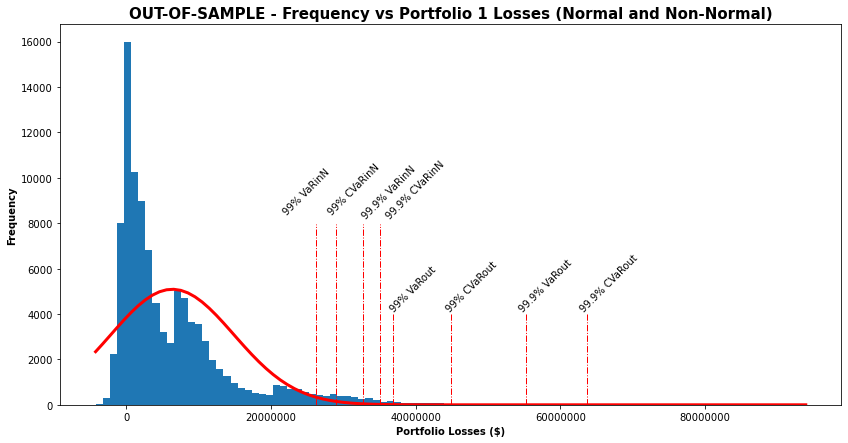

In [19]:
resz_0 = np.dot(Losses_out,x0[0])
fig, ax = plt.subplots(figsize=(14,7))
frequencyCounts, binLocations, patches = plt.hist(resz_0, 100)
normf = (1 / (np.std(resz_0) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(resz_0)) /\
                                                                         np.std(resz_0)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
# 99%
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')

# 99.9%
# plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')#
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#

# 99%
plt.text(0.98 * VaRout[0,0], max(frequencyCounts) / 3.9, '99% VaRout', rotation=45) #
plt.text(0.82 * VaRinN[0,0], max(frequencyCounts) / 1.9, '99% VaRinN', rotation=45)
plt.text(0.98 * CVaRout[0,0], max(frequencyCounts) / 3.9, '99% CVaRout', rotation=45) #
plt.text(0.95 * CVaRinN[0,0], max(frequencyCounts) / 1.9, '99% CVaRinN', rotation=45)

# 99.9%
plt.text(0.98 * VaRout[0,1], max(frequencyCounts) / 3.9, '99.9% VaRout', rotation=45) #
plt.text(0.99 * VaRinN[0,1], max(frequencyCounts) / 1.95, '99.9% VaRinN', rotation=45)
plt.text(0.98 * CVaRout[0,1], max(frequencyCounts) / 3.9, '99.9% CVaRout', rotation=45) #
plt.text(1.02 * CVaRinN[0,1], max(frequencyCounts) / 1.95, '99.9% CVaRinN', rotation=45) 

plt.title('OUT-OF-SAMPLE - Frequency vs Portfolio 1 Losses (Normal and Non-Normal)',\
          fontsize = 15,fontdict=dict(weight='bold'))
plt.xlabel('Portfolio Losses ($)',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Frequency',fontsize = 10, fontdict=dict(weight='bold'))
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.show()

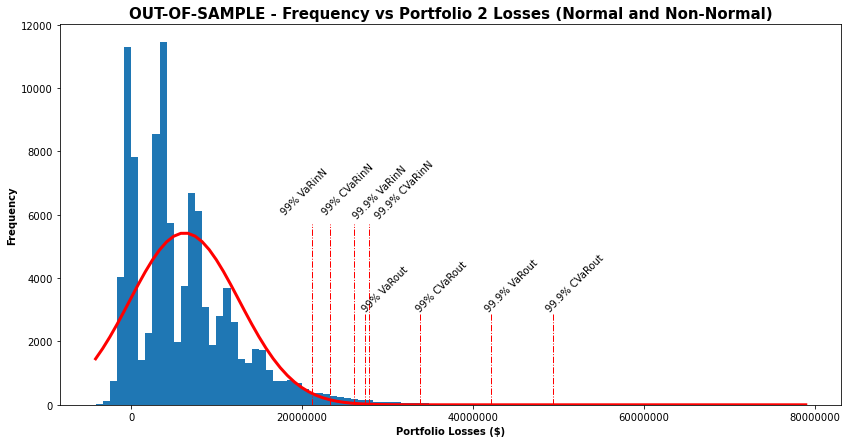

In [20]:
resz_1 = np.dot(Losses_out,x0[1])
fig, ax = plt.subplots(figsize=(14,7))
frequencyCounts, binLocations, patches = plt.hist(resz_1, 100)
normf = (1 / (np.std(resz_1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(resz_1)) /\
                                                                         np.std(resz_1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
# 99%
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')

# 99.9%
# plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')#
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#

# 99%
plt.text(0.98 * VaRout[1,0], max(frequencyCounts) / 3.9, '99% VaRout', rotation=45) #
plt.text(0.82 * VaRinN[1,0], max(frequencyCounts) / 1.9, '99% VaRinN', rotation=45)
plt.text(0.98 * CVaRout[1,0], max(frequencyCounts) / 3.9, '99% CVaRout', rotation=45) #
plt.text(0.95 * CVaRinN[1,0], max(frequencyCounts) / 1.9, '99% CVaRinN', rotation=45)

# 99.9%
plt.text(0.98 * VaRout[1,1], max(frequencyCounts) / 3.9, '99.9% VaRout', rotation=45) #
plt.text(0.99 * VaRinN[1,1], max(frequencyCounts) / 1.95, '99.9% VaRinN', rotation=45)
plt.text(0.98 * CVaRout[1,1], max(frequencyCounts) / 3.9, '99.9% CVaRout', rotation=45) #
plt.text(1.02 * CVaRinN[1,1], max(frequencyCounts) / 1.95, '99.9% CVaRinN', rotation=45) 

plt.title('OUT-OF-SAMPLE - Frequency vs Portfolio 2 Losses (Normal and Non-Normal)',\
          fontsize = 15,fontdict=dict(weight='bold'))
plt.xlabel('Portfolio Losses ($)',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Frequency',fontsize = 10, fontdict=dict(weight='bold'))
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.show()

### Plot 2 (Monte Carlo 1)

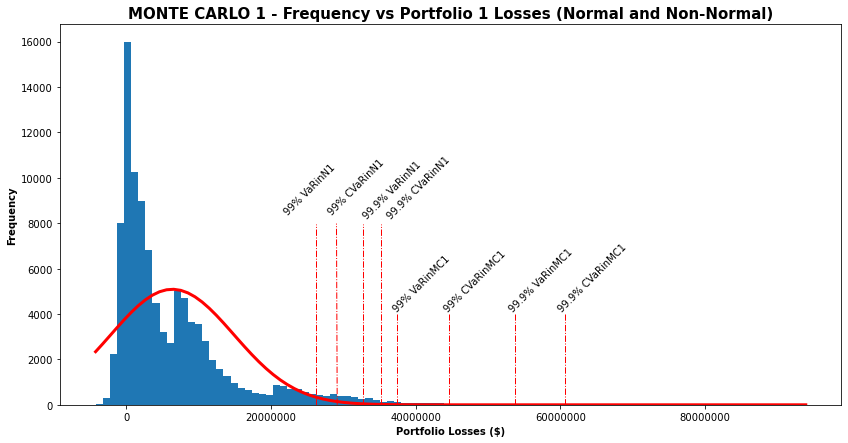

In [137]:
resz_0 = np.dot(Losses_out,x0[0])
fig, ax = plt.subplots(figsize=(14,7))
frequencyCounts, binLocations, patches = plt.hist(resz_0, 100)
normf = (1 / (np.std(resz_0) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(resz_0)) /\
                                                                         np.std(resz_0)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

# 99%
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRinMC1[0,0].mean(), VaRinMC1[0,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([VaRinN1[0,0].mean(), VaRinN1[0,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[0,0].mean(), CVaRinMC1[0,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([CVaRinN1[0,0].mean(), CVaRinN[0,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')

# 99.9%
plt.plot([VaRinMC1[0,1].mean(), VaRinMC1[0,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')#
plt.plot([VaRinN1[0,1].mean(), VaRinN1[0,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[0,1].mean(), CVaRinMC1[0,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[0,1].mean(), CVaRinN1[0,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#

# 99%
plt.text(0.98 * VaRinMC1[0,0].mean(), max(frequencyCounts) / 3.9, '99% VaRinMC1', rotation=45) #
plt.text(0.82 * VaRinN1[0,0].mean(), max(frequencyCounts) / 1.9, '99% VaRinN1', rotation=45)
plt.text(0.98 * CVaRinMC1[0,0].mean(), max(frequencyCounts) / 3.9, '99% CVaRinMC1', rotation=45) #
plt.text(0.95 * CVaRinN1[0,0].mean(), max(frequencyCounts) / 1.9, '99% CVaRinN1', rotation=45)

# 99.9%
plt.text(0.98 * VaRinMC1[0,1].mean(), max(frequencyCounts) / 3.9, '99.9% VaRinMC1', rotation=45) #
plt.text(0.99 * VaRinN1[0,1].mean(), max(frequencyCounts) / 1.95, '99.9% VaRinN1', rotation=45)
plt.text(0.98 * CVaRinMC1[0,1].mean(), max(frequencyCounts) / 3.9, '99.9% CVaRinMC1', rotation=45) #
plt.text(1.02 * CVaRinN1[0,1].mean(), max(frequencyCounts) / 1.95, '99.9% CVaRinN1', rotation=45) 

plt.title('MONTE CARLO 1 - Frequency vs Portfolio 1 Losses (Normal and Non-Normal)',\
          fontsize = 15,fontdict=dict(weight='bold'))
plt.xlabel('Portfolio Losses ($)',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Frequency',fontsize = 10, fontdict=dict(weight='bold'))
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.show()

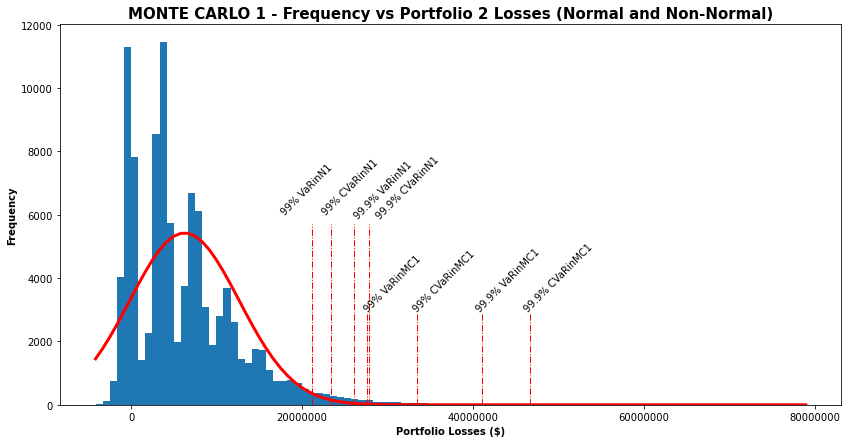

In [136]:
resz_1 = np.dot(Losses_out,x0[1])
fig, ax = plt.subplots(figsize=(14,7))
frequencyCounts, binLocations, patches = plt.hist(resz_1, 100)
normf = (1 / (np.std(resz_1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(resz_1)) /\
                                                                         np.std(resz_1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

# 99%
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRinMC1[1,0].mean(), VaRinMC1[1,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([VaRinN1[1,0].mean(), VaRinN1[1,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[1,0].mean(), CVaRinMC1[1,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([CVaRinN1[1,0].mean(), CVaRinN1[1,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')

# 99.9%
plt.plot([VaRinMC1[1,1].mean(), VaRinMC1[1,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')#
plt.plot([VaRinN1[1,1].mean(), VaRinN1[1,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC1[1,1].mean(), CVaRinMC1[1,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN1[1,1].mean(), CVaRinN1[1,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#

# 99%
plt.text(0.98 * VaRinMC1[1,0].mean(), max(frequencyCounts) / 3.9, '99% VaRinMC1', rotation=45) #
plt.text(0.82 * VaRinN1[1,0].mean(), max(frequencyCounts) / 1.9, '99% VaRinN1', rotation=45)
plt.text(0.98 * CVaRinMC1[1,0].mean(), max(frequencyCounts) / 3.9, '99% CVaRinMC1', rotation=45) #
plt.text(0.95 * CVaRinN1[1,0].mean(), max(frequencyCounts) / 1.9, '99% CVaRinN1', rotation=45)

# 99.9%
plt.text(0.98 * VaRinMC1[1,1].mean(), max(frequencyCounts) / 3.9, '99.9% VaRinMC1', rotation=45) #
plt.text(0.99 * VaRinN1[1,1].mean(), max(frequencyCounts) / 1.95, '99.9% VaRinN1', rotation=45)
plt.text(0.98 * CVaRinMC1[1,1].mean(), max(frequencyCounts) / 3.9, '99.9% CVaRinMC1', rotation=45) #
plt.text(1.02 * CVaRinN1[1,1].mean(), max(frequencyCounts) / 1.95, '99.9% CVaRinN1', rotation=45) 

plt.title('MONTE CARLO 1 - Frequency vs Portfolio 2 Losses (Normal and Non-Normal)',\
          fontsize = 15,fontdict=dict(weight='bold'))
plt.xlabel('Portfolio Losses ($)',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Frequency',fontsize = 10, fontdict=dict(weight='bold'))
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.show()

### Plot 3 (Monte Carlo 2)

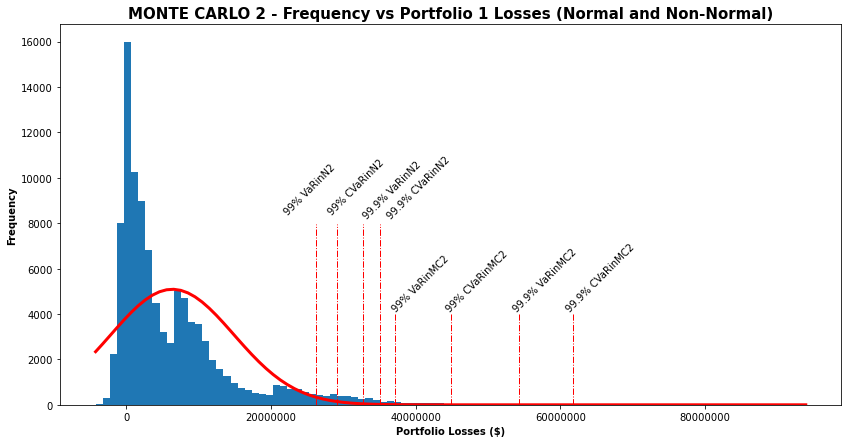

In [135]:
resz_0 = np.dot(Losses_out,x0[0])
fig, ax = plt.subplots(figsize=(14,7))
frequencyCounts, binLocations, patches = plt.hist(resz_0, 100)
normf = (1 / (np.std(resz_0) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(resz_0)) /\
                                                                         np.std(resz_0)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

# 99%
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRinMC2[0,0].mean(), VaRinMC2[0,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([VaRinN2[0,0].mean(), VaRinN2[0,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[0,0].mean(), CVaRinMC2[0,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([CVaRinN2[0,0].mean(), CVaRinN2[0,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')

# 99.9%
plt.plot([VaRinMC2[0,1].mean(), VaRinMC2[0,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')#
plt.plot([VaRinN2[0,1].mean(), VaRinN2[0,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[0,1].mean(), CVaRinMC2[0,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN2[0,1].mean(), CVaRinN2[0,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#

# 99%
plt.text(0.98 * VaRinMC2[0,0].mean(), max(frequencyCounts) / 3.9, '99% VaRinMC2', rotation=45) #
plt.text(0.82 * VaRinN2[0,0].mean(), max(frequencyCounts) / 1.9, '99% VaRinN2', rotation=45)
plt.text(0.98 * CVaRinMC2[0,0].mean(), max(frequencyCounts) / 3.9, '99% CVaRinMC2', rotation=45) #
plt.text(0.95 * CVaRinN2[0,0].mean(), max(frequencyCounts) / 1.9, '99% CVaRinN2', rotation=45)

# 99.9%
plt.text(0.98 * VaRinMC2[0,1].mean(), max(frequencyCounts) / 3.9, '99.9% VaRinMC2', rotation=45) #
plt.text(0.99 * VaRinN2[0,1].mean(), max(frequencyCounts) / 1.95, '99.9% VaRinN2', rotation=45)
plt.text(0.98 * CVaRinMC2[0,1].mean(), max(frequencyCounts) / 3.9, '99.9% CVaRinMC2', rotation=45) #
plt.text(1.02 * CVaRinN2[0,1].mean(), max(frequencyCounts) / 1.95, '99.9% CVaRinN2', rotation=45) 

plt.title('MONTE CARLO 2 - Frequency vs Portfolio 1 Losses (Normal and Non-Normal)',\
          fontsize = 15,fontdict=dict(weight='bold'))
plt.xlabel('Portfolio Losses ($)',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Frequency',fontsize = 10, fontdict=dict(weight='bold'))
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.show()

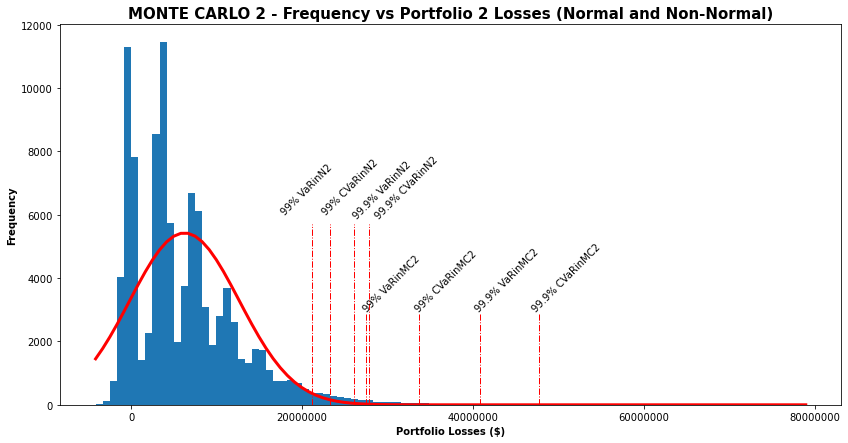

In [134]:
resz_1 = np.dot(Losses_out,x0[1])
fig, ax = plt.subplots(figsize=(14,7))
frequencyCounts, binLocations, patches = plt.hist(resz_1, 100)
normf = (1 / (np.std(resz_1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(resz_1)) /\
                                                                         np.std(resz_1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

# 99%
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRinMC2[1,0].mean(), VaRinMC2[1,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([VaRinN2[1,0].mean(), VaRinN2[1,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[1,0].mean(), CVaRinMC2[1,0].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.') #
plt.plot([CVaRinN2[1,0].mean(), CVaRinN2[1,0].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')

# 99.9%
plt.plot([VaRinMC2[1,1].mean(), VaRinMC2[1,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')#
plt.plot([VaRinN2[1,1].mean(), VaRinN2[1,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinMC2[1,1].mean(), CVaRinMC2[1,1].mean()], [0, max(frequencyCounts) / 4], color='r', linewidth=1, linestyle='-.')
plt.plot([CVaRinN2[1,1].mean(), CVaRinN2[1,1].mean()], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')#

# 99%
plt.text(0.98 * VaRinMC2[1,0].mean(), max(frequencyCounts) / 3.9, '99% VaRinMC2', rotation=45) #
plt.text(0.82 * VaRinN2[1,0].mean(), max(frequencyCounts) / 1.9, '99% VaRinN2', rotation=45)
plt.text(0.98 * CVaRinMC2[1,0].mean(), max(frequencyCounts) / 3.9, '99% CVaRinMC2', rotation=45) #
plt.text(0.95 * CVaRinN2[1,0].mean(), max(frequencyCounts) / 1.9, '99% CVaRinN2', rotation=45)

# 99.9%
plt.text(0.98 * VaRinMC2[1,1].mean(), max(frequencyCounts) / 3.9, '99.9% VaRinMC2', rotation=45) #
plt.text(0.99 * VaRinN2[1,1].mean(), max(frequencyCounts) / 1.95, '99.9% VaRinN2', rotation=45)
plt.text(0.98 * CVaRinMC2[1,1].mean(), max(frequencyCounts) / 3.9, '99.9% CVaRinMC2', rotation=45) #
plt.text(1.02 * CVaRinN2[1,1].mean(), max(frequencyCounts) / 1.95, '99.9% CVaRinN2', rotation=45) 

plt.title('MONTE CARLO 2 - Frequency vs Portfolio 2 Losses (Normal and Non-Normal)',\
          fontsize = 15,fontdict=dict(weight='bold'))
plt.xlabel('Portfolio Losses ($)',fontsize = 10, fontdict=dict(weight='bold'))
plt.ylabel('Frequency',fontsize = 10, fontdict=dict(weight='bold'))
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
plt.show()

### Sampling Error

In [260]:
# portfolio 1 99%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[0,0], VaRinMC1[0,0].mean(), VaRinMC2[0,0].mean()],\
     'VaR Std Dev': [np.std(VaRout[0,0]), np.std(VaRinMC1[0,0]), np.std(VaRinMC2[0,0])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(VaRout[0,0] - VaRinMC1[0,0].mean()) /\
                                              ((VaRinMC1[0,0].mean() + VaRout[0,0])*0.5)*100,\
                                              abs(VaRout[0,0] - VaRinMC2[0,0].mean()) /\
                                              ((VaRinMC2[0,0].mean() + VaRout[0,0])*0.5)*100],\
     'CVaR': [CVaRout[0,0], CVaRinMC1[0,0].mean(), CVaRinMC2[0,0].mean()],\
     'CVaR Std Dev': [np.std(CVaRout[0,0]), np.std(CVaRinMC1[0,0]), np.std(CVaRinMC2[0,0])],\
    'CVaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(CVaRout[0,0] - CVaRinMC1[0,0].mean()) /\
                                              ((CVaRinMC1[0,0].mean() + CVaRout[0,0])*0.5)*100,\
                                              abs(CVaRout[0,0] - CVaRinMC2[0,0].mean()) /\
                                              ((CVaRinMC2[0,0].mean() + CVaRout[0,0])*0.5)*100]}

sample_error_port_1_99 = pd.DataFrame(data=d, index=['True Distribution', 'MC1 Port 1 99%', 'MC2 Port 1 99%'])
sample_error_port_1_99

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%)
True Distribution,"36,889,218.48",0.00,0.00,"44,815,405.91",0.00,0.00
MC1 Port 1 99%,"37,362,378.70","1,337,911.81",1.27,"44,546,740.42","1,940,865.69",0.60
MC2 Port 1 99%,"37,168,403.19","1,118,566.65",0.75,"44,831,892.86","1,577,191.32",0.04


In [261]:
# portfolio 1 99.9%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[0,1], VaRinMC1[0,1].mean(), VaRinMC2[0,1].mean()],\
     'VaR Std Dev': [np.std(VaRout[0,1]), np.std(VaRinMC1[0,1]), np.std(VaRinMC2[0,1])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(VaRout[0,1] - VaRinMC1[0,1].mean()) /\
                                              ((VaRinMC1[0,1].mean() + VaRout[0,1])*0.5)*100,\
                                              abs(VaRout[0,1] - VaRinMC2[0,1].mean()) /\
                                              ((VaRinMC2[0,1].mean() + VaRout[0,1])*0.5)*100],\
     'CVaR': [CVaRout[0,1], CVaRinMC1[0,1].mean(), CVaRinMC2[0,1].mean()],\
    'CVaR Std Dev': [np.std(CVaRout[0,1]), np.std(CVaRinMC1[0,1]), np.std(CVaRinMC2[0,1])],\
    'CVaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(CVaRout[0,1] - CVaRinMC1[0,1].mean()) /\
                                              ((CVaRinMC1[0,1].mean() + CVaRout[0,1])*0.5)*100,\
                                              abs(CVaRout[0,1] - CVaRinMC2[0,1].mean()) /\
                                              ((CVaRinMC2[0,1].mean() + CVaRout[0,1])*0.5)*100]}

sample_error_port_1_399 = pd.DataFrame(data=d, index=['True Distribution', 'MC1 Port 1 99.9%', 'MC2 Port 1 99.9%'])
sample_error_port_1_399

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%)
True Distribution,"55,191,043.34",0.00,0.00,"63,711,861.81",0.00,0.00
MC1 Port 1 99.9%,"53,770,875.13","3,909,971.40",2.61,"60,596,034.32","5,674,586.37",5.01
MC2 Port 1 99.9%,"54,225,273.86","3,659,593.94",1.77,"61,705,531.85","4,426,606.15",3.20


In [263]:
# portfolio 2 99%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[1,0], VaRinMC1[1,0].mean(), VaRinMC2[1,0].mean()],\
     'VaR Std Dev': [np.std(VaRout[1,0]), np.std(VaRinMC1[1,0]), np.std(VaRinMC2[1,0])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(VaRout[1,0] - VaRinMC1[1,0].mean()) /\
                                              ((VaRinMC1[1,0].mean() + VaRout[1,0])*0.5)*100,\
                                              abs(VaRout[1,0] - VaRinMC2[1,0].mean()) /\
                                              ((VaRinMC2[1,0].mean() + VaRout[1,0])*0.5)*100],\
     'CVaR': [CVaRout[1,0], CVaRinMC1[1,0].mean(), CVaRinMC2[1,0].mean()],\
    'CVaR Std Dev': [np.std(CVaRout[1,0]), np.std(CVaRinMC1[1,0]), np.std(CVaRinMC2[1,0])],\
     'CVaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(CVaRout[1,0] - CVaRinMC1[1,0].mean()) /\
                                              ((CVaRinMC1[1,0].mean() + CVaRout[1,0])*0.5)*100,\
                                              abs(CVaRout[1,0] - CVaRinMC2[1,0].mean()) /\
                                              ((CVaRinMC2[1,0].mean() + CVaRout[1,0])*0.5)*100]}

sample_error_port_2_99 = pd.DataFrame(data=d, index=['True Distribution', 'MC1 Port 2 99%', 'MC2 Port 2 99%'])
sample_error_port_2_99

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%)
True Distribution,"27,373,502.27",0.00,0.00,"33,814,431.69",0.00,0.00
MC1 Port 2 99%,"27,555,575.89","1,240,474.77",0.66,"33,490,522.13","1,967,482.68",0.96
MC2 Port 2 99%,"27,490,918.05","777,500.54",0.43,"33,627,209.81","1,275,267.62",0.56


In [262]:
# portfolio 2 99.9%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[1,1], VaRinMC1[1,1].mean(), VaRinMC2[1,1].mean()],\
     'VaR Std Dev': [np.std(VaRout[1,1]), np.std(VaRinMC1[1,1]), np.std(VaRinMC2[1,1])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(VaRout[1,1] - VaRinMC1[1,1].mean()) /\
                                              ((VaRinMC1[1,1].mean() + VaRout[1,1])*0.5)*100,\
                                              abs(VaRout[1,1] - VaRinMC2[1,1].mean()) /\
                                              ((VaRinMC2[1,1].mean() + VaRout[1,1])*0.5)*100],\
     'CVaR': [CVaRout[1,1], CVaRinMC1[1,1].mean(), CVaRinMC2[1,1].mean()],\
    'CVaR Std Dev': [np.std(CVaRout[1,1]), np.std(CVaRinMC1[1,1]), np.std(CVaRinMC2[1,1])],\
     'CVaR Percent\
     Difference with True Distribution (%)': [0,\
                                              abs(CVaRout[1,1] - CVaRinMC1[1,1].mean()) /\
                                              ((CVaRinMC1[1,1].mean() + CVaRout[1,1])*0.5)*100,\
                                              abs(CVaRout[1,1] - CVaRinMC2[1,1].mean()) /\
                                              ((CVaRinMC2[1,1].mean() + CVaRout[1,1])*0.5)*100]}

sample_error_port_2_399 = pd.DataFrame(data=d, index=['True Distribution', 'MC1 Port 2 99.9%', 'MC2 Port 2 99.9%'])
sample_error_port_2_399

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%)
True Distribution,"42,041,862.95",0.00,0.00,"49,350,770.69",0.00,0.00
MC1 Port 2 99.9%,"40,999,030.96","3,795,172.66",2.51,"46,683,236.06","5,832,589.29",5.56
MC2 Port 2 99.9%,"40,799,156.05","2,558,229.47",3.00,"47,705,051.91","4,050,564.09",3.39


### Model Error

In [34]:
# portfolio 1 99%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[0,0], VaRinN[0,0], VaRinN1[0,0].mean(), VaRinN2[0,0].mean()],\
     'VaR Std Dev': [np.std(VaRout[0,0]), np.std(VaRinN[0,0]), np.std(VaRinN1[0,0]), np.std(VaRinN2[0,0])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,abs(VaRout[0,0] - VaRinN[0,0]) /\
                                              ((VaRinN[0,0] + VaRout[0,0])*0.5)*100,\
                                              abs(VaRout[0,0] - VaRinN1[0,0].mean()) /\
                                              ((VaRinN1[0,0].mean() + VaRout[0,0])*0.5)*100,\
                                              abs(VaRout[0,0] - VaRinN2[0,0].mean()) /\
                                              ((VaRinN2[0,0].mean() + VaRout[0,0])*0.5)*100],\
     'VaR Percent\
     Difference with Normal True Distribution (%)': [abs(VaRout[0,0] - VaRinN[0,0])/((VaRinN[0,0] + VaRout[0,0])*0.5)*100\
                                                     ,0,\
                                              abs(VaRinN[0,0] - VaRinN1[0,0].mean()) /\
                                              ((VaRinN1[0,0].mean() + VaRinN[0,0])*0.5)*100,\
                                              abs(VaRinN[0,0] - VaRinN2[0,0].mean()) /\
                                              ((VaRinN2[0,0].mean() + VaRinN[0,0])*0.5)*100],\
     'CVaR': [CVaRout[0,0], CVaRinN[0,0], CVaRinN1[0,0].mean(), CVaRinN2[0,0].mean()],\
    'CVaR Std Dev': [np.std(CVaRout[0,0]), np.std(VaRinN[0,0]), np.std(CVaRinN1[0,0]), np.std(CVaRinN2[0,0])],\
     'CVaR Percent\
     Difference with True Distribution (%)': [0,abs(CVaRout[0,0] - CVaRinN[0,0]) /\
                                              ((CVaRinN[0,0] + CVaRout[0,0])*0.5)*100,\
                                              abs(CVaRout[0,0] - CVaRinN1[0,0].mean()) /\
                                              ((CVaRinN1[0,0].mean() + CVaRout[0,0])*0.5)*100,\
                                              abs(CVaRout[0,0] - CVaRinN2[0,0].mean()) /\
                                              ((CVaRinN2[0,0].mean() + CVaRout[0,0])*0.5)*100],\
    'CVaR Percent\
     Difference with Normal True Distribution (%)': [abs(CVaRout[0,0] - CVaRinN[0,0])/((CVaRinN[0,0] + CVaRout[0,0])*0.5)*100\
                                                     ,0,\
                                              abs(CVaRinN[0,0] - CVaRinN1[0,0].mean()) /\
                                              ((CVaRinN1[0,0].mean() + CVaRinN[0,0])*0.5)*100,\
                                              abs(CVaRinN[0,0] - CVaRinN2[0,0].mean()) /\
                                              ((CVaRinN2[0,0].mean() + CVaRinN[0,0])*0.5)*100]}

sample_error_port_1_99_n = pd.DataFrame(data=d, index=['True Distribution','Normal OOS', 'nMC1 Port 1 99%', 'nMC2 Port 1 99%'])
sample_error_port_1_99_n

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),VaR Percent Difference with Normal True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%),CVaR Percent Difference with Normal True Distribution (%)
True Distribution,"36,889,218.48",0.00,0.00,34.06,"44,815,405.91",0.00,0.00,42.73
Normal OOS,"26,152,334.34",0.00,34.06,0.00,"29,036,839.79",0.00,42.73,0.00
nMC1 Port 1 99%,"26,241,842.05","669,916.27",33.73,0.34,"29,136,471.72","744,680.54",42.40,0.34
nMC2 Port 1 99%,"26,217,669.43","509,341.90",33.82,0.25,"29,109,561.62","567,576.53",42.49,0.25


In [37]:
# portfolio 1 99.9%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[0,1], VaRinN[0,1], VaRinN1[0,1].mean(), VaRinN2[0,1].mean()],\
     'VaR Std Dev': [np.std(VaRout[0,1]), np.std(VaRinN[0,1]), np.std(VaRinN1[0,1]), np.std(VaRinN2[0,1])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,abs(VaRout[0,1] - VaRinN[0,1]) /\
                                              ((VaRinN[0,1] + VaRout[0,1])*0.5)*100,\
                                              abs(VaRout[0,1] - VaRinN1[0,1].mean()) /\
                                              ((VaRinN1[0,1].mean() + VaRout[0,1])*0.5)*100,\
                                              abs(VaRout[0,1] - VaRinN2[0,1].mean()) /\
                                              ((VaRinN2[0,1].mean() + VaRout[0,1])*0.5)*100],\
     'VaR Percent\
     Difference with Normal True Distribution (%)': [abs(VaRout[0,1] - VaRinN[0,1])/((VaRinN[0,1] + VaRout[0,1])*0.5)*100\
                                                     ,0,\
                                              abs(VaRinN[0,1] - VaRinN1[0,1].mean()) /\
                                              ((VaRinN1[0,1].mean() + VaRinN[0,1])*0.5)*100,\
                                              abs(VaRinN[0,1] - VaRinN2[0,1].mean()) /\
                                              ((VaRinN2[0,1].mean() + VaRinN[0,1])*0.5)*100],\
     'CVaR': [CVaRout[0,1], CVaRinN[0,1], CVaRinN1[0,1].mean(), CVaRinN2[0,1].mean()],\
    'CVaR Std Dev': [np.std(CVaRout[0,1]), np.std(VaRinN[0,1]), np.std(CVaRinN1[0,1]), np.std(CVaRinN2[0,1])],\
     'CVaR Percent\
     Difference with True Distribution (%)': [0,abs(CVaRout[0,1] - CVaRinN[0,1]) /\
                                              ((CVaRinN[0,1] + CVaRout[0,1])*0.5)*100,\
                                              abs(CVaRout[0,1] - CVaRinN1[0,1].mean()) /\
                                              ((CVaRinN1[0,1].mean() + CVaRout[0,1])*0.5)*100,\
                                              abs(CVaRout[0,1] - CVaRinN2[0,1].mean()) /\
                                              ((CVaRinN2[0,1].mean() + CVaRout[0,1])*0.5)*100],\
     'CVaR Percent\
     Difference with Normal True Distribution (%)': [abs(CVaRout[0,1] - CVaRinN[0,1])/((CVaRinN[0,1] + CVaRout[0,1])*0.5)*100\
                                                     ,0,\
                                              abs(CVaRinN[0,1] - CVaRinN1[0,1].mean()) /\
                                              ((CVaRinN1[0,1].mean() + CVaRinN[0,1])*0.5)*100,\
                                              abs(CVaRinN[0,1] - CVaRinN2[0,1].mean()) /\
                                              ((CVaRinN2[0,1].mean() + CVaRinN[0,1])*0.5)*100]}

sample_error_port_1_399_n = pd.DataFrame(data=d, index=['True Distribution','Normal OOS', 'nMC1 Port 1 99.9%', 'nMC2 Port 1 99.9%'])
sample_error_port_1_399_n

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),VaR Percent Difference with Normal True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%),CVaR Percent Difference with Normal True Distribution (%)
True Distribution,"55,191,043.34",0.00,0.00,51.31,"63,711,861.81",0.00,0.00,58.14
Normal OOS,"32,654,687.95",0.00,51.31,0.00,"35,011,362.66",0.00,58.14,0.00
nMC1 Port 1 99.9%,"32,767,018.03","838,710.38",50.99,0.34,"35,131,964.35","900,076.49",57.83,0.34
nMC2 Port 1 99.9%,"32,736,674.49","640,755.62",51.07,0.25,"35,099,384.25","688,486.28",57.91,0.25


In [38]:
# portfolio 2 99%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[1,0], VaRinN[1,0], VaRinN1[1,0].mean(), VaRinN2[1,0].mean()],\
     'VaR Std Dev': [np.std(VaRout[1,0]), np.std(VaRinN[1,0]), np.std(VaRinN1[1,0]), np.std(VaRinN2[1,0])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,abs(VaRout[1,0] - VaRinN[1,0]) /\
                                              ((VaRinN[1,0] + VaRout[1,0])*0.5)*100,\
                                              abs(VaRout[1,0] - VaRinN1[1,0].mean()) /\
                                              ((VaRinN1[1,0].mean() + VaRout[1,0])*0.5)*100,\
                                              abs(VaRout[1,0] - VaRinN2[1,0].mean()) /\
                                              ((VaRinN2[1,0].mean() + VaRout[1,0])*0.5)*100],\
     'VaR Percent\
     Difference with Normal True Distribution (%)': [abs(VaRout[1,0] - VaRinN[1,0])/((VaRinN[1,0] + VaRout[1,0])*0.5)*100\
                                                     ,0,\
                                              abs(VaRinN[1,0] - VaRinN1[1,0].mean()) /\
                                              ((VaRinN1[1,0].mean() + VaRinN[1,0])*0.5)*100,\
                                              abs(VaRinN[1,0] - VaRinN2[1,0].mean()) /\
                                              ((VaRinN2[1,0].mean() + VaRinN[1,0])*0.5)*100],\
     'CVaR': [CVaRout[1,0], CVaRinN[1,0], CVaRinN1[1,0].mean(), CVaRinN2[1,0].mean()],\
    'CVaR Std Dev': [np.std(CVaRout[1,0]), np.std(VaRinN[1,0]), np.std(CVaRinN1[1,0]), np.std(CVaRinN2[1,0])],\
     'CVaR Percent\
     Difference with True Distribution (%)': [0,abs(CVaRout[1,0] - CVaRinN[1,0]) /\
                                              ((CVaRinN[1,0] + CVaRout[1,0])*0.5)*100,\
                                              abs(CVaRout[1,0] - CVaRinN1[1,0].mean()) /\
                                              ((CVaRinN1[1,0].mean() + CVaRout[1,0])*0.5)*100,\
                                              abs(CVaRout[1,0] - CVaRinN2[1,0].mean()) /\
                                              ((CVaRinN2[1,0].mean() + CVaRout[1,0])*0.5)*100],\
     'CVaR Percent\
     Difference with Normal True Distribution (%)': [abs(CVaRout[1,0] - CVaRinN[1,0])/((CVaRinN[1,0] + CVaRout[1,0])*0.5)*100\
                                                     ,0,\
                                              abs(CVaRinN[1,0] - CVaRinN1[1,0].mean()) /\
                                              ((CVaRinN1[1,0].mean() + CVaRinN[1,0])*0.5)*100,\
                                              abs(CVaRinN[1,0] - CVaRinN2[1,0].mean()) /\
                                              ((CVaRinN2[1,0].mean() + CVaRinN[1,0])*0.5)*100]}

sample_error_port_2_99_n = pd.DataFrame(data=d, index=['True Distribution','Normal OOS', 'nMC1 Port 2 99%', 'nMC2 Port 2 99%'])
sample_error_port_2_99_n

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),VaR Percent Difference with Normal True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%),CVaR Percent Difference with Normal True Distribution (%)
True Distribution,"27,373,502.27",0.00,0.00,25.77,"33,814,431.69",0.00,0.00,36.84
Normal OOS,"21,124,958.26",0.00,25.77,0.00,"23,294,619.23",0.00,36.84,0.00
nMC1 Port 2 99%,"21,178,420.19","540,302.18",25.52,0.25,"23,353,510.68","601,149.35",36.60,0.25
nMC2 Port 2 99%,"21,139,377.58","334,934.42",25.70,0.07,"23,309,609.67","373,610.93",36.78,0.06


In [39]:
# portfolio 2 99.9%
pd.options.display.float_format = '{:,.2f}'.format
d = {'VaR': [VaRout[1,1], VaRinN[1,1], VaRinN1[1,1].mean(), VaRinN2[1,1].mean()],\
     'VaR Std Dev': [np.std(VaRout[1,1]), np.std(VaRinN[1,1]), np.std(VaRinN1[1,1]), np.std(VaRinN2[1,1])],\
     'VaR Percent\
     Difference with True Distribution (%)': [0,abs(VaRout[1,1] - VaRinN[1,1]) /\
                                              ((VaRinN[1,1] + VaRout[1,1])*0.5)*100,\
                                              abs(VaRout[1,1] - VaRinN1[1,1].mean()) /\
                                              ((VaRinN1[1,1].mean() + VaRout[1,1])*0.5)*100,\
                                              abs(VaRout[1,1] - VaRinN2[1,1].mean()) /\
                                              ((VaRinN2[1,1].mean() + VaRout[1,1])*0.5)*100],\
     'VaR Percent\
     Difference with Normal True Distribution (%)': [abs(VaRout[1,1] - VaRinN[1,1])/((VaRinN[1,1] + VaRout[1,1])*0.5)*100\
                                                     ,0,\
                                              abs(VaRinN[1,1] - VaRinN1[1,1].mean()) /\
                                              ((VaRinN1[1,1].mean() + VaRinN[1,1])*0.5)*100,\
                                              abs(VaRinN[1,1] - VaRinN2[1,1].mean()) /\
                                              ((VaRinN2[1,1].mean() + VaRinN[1,1])*0.5)*100],\
     'CVaR': [CVaRout[1,1], CVaRinN[1,1], CVaRinN1[1,1].mean(), CVaRinN2[1,1].mean()],\
    'CVaR Std Dev': [np.std(CVaRout[1,1]), np.std(VaRinN[1,1]), np.std(CVaRinN1[1,1]), np.std(CVaRinN2[1,1])],\
     'CVaR Percent\
     Difference with True Distribution (%)': [0,abs(CVaRout[1,1] - CVaRinN[1,1]) /\
                                              ((CVaRinN[1,1] + CVaRout[1,1])*0.5)*100,\
                                              abs(CVaRout[1,1] - CVaRinN1[1,1].mean()) /\
                                              ((CVaRinN1[1,1].mean() + CVaRout[1,1])*0.5)*100,\
                                              abs(CVaRout[1,1] - CVaRinN2[1,1].mean()) /\
                                              ((CVaRinN2[1,1].mean() + CVaRout[1,1])*0.5)*100],\
     'CVaR Percent\
     Difference with Normal True Distribution (%)': [abs(CVaRout[1,1] - CVaRinN[1,1])/((CVaRinN[1,1] + CVaRout[1,1])*0.5)*100\
                                                     ,0,\
                                              abs(CVaRinN[1,1] - CVaRinN1[1,1].mean()) /\
                                              ((CVaRinN1[1,1].mean() + CVaRinN[1,1])*0.5)*100,\
                                              abs(CVaRinN[1,1] - CVaRinN2[1,1].mean()) /\
                                              ((CVaRinN2[1,1].mean() + CVaRinN[1,1])*0.5)*100]}

sample_error_port_2_399_n = pd.DataFrame(data=d, index=['True Distribution','Normal OOS', 'nMC1 Port 2 99.9%',\
                                                       'nMC2 Port 2 99.9%'])
sample_error_port_2_399_n

,VaR,VaR Std Dev,VaR Percent Difference with True Distribution (%),VaR Percent Difference with Normal True Distribution (%),CVaR,CVaR Std Dev,CVaR Percent Difference with True Distribution (%),CVaR Percent Difference with Normal True Distribution (%)
True Distribution,"42,041,862.95",0.00,0.00,47.10,"49,350,770.69",0.00,0.00,55.90
Normal OOS,"26,015,884.30",0.00,47.10,0.00,"27,788,522.70",0.00,55.90,0.00
nMC1 Port 2 99.9%,"26,081,585.64","677,782.68",46.86,0.25,"27,858,660.03","727,842.48",55.67,0.25
nMC2 Port 2 99.9%,"26,031,591.05","422,296.82",47.04,0.06,"27,804,696.07","454,088.81",55.85,0.06
